In [8]:
import numpy as np
import pandas as pd
import scipy.special 
import matplotlib.pyplot as plt 
from math import *


In [9]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [10]:
def american_binomial_model(S, K, T, r, q, sigma, N, flag = 'c') -> float:
    ''' Binomial model calculating the price of American call and put options.

    Keyword arguments: 
    S -- Stock price at time zero
    K -- Option exercise price 
    T -- Time to maturity (in years)
    r -- Continuously compounded annual interest rate
    q -- Annual continuous dividend yield
    sigma -- Volatility
    N -- Number of steps in a binomial tree
    flag -- 'c' for call and 'p' for put (default = call) 
    '''
    dt = T/N # Length of binomial period in years
    u = np.exp((r - q) * dt + sigma * np.sqrt(dt))
    d = np.exp((r - q) * dt - sigma * np.sqrt(dt))
    p = (np.exp((r - q) * dt) - d) / (u - d)
    discount = np.exp(-r * dt)

    if flag == 'c':
        z = 1
    else:
        z = -1 

    # Arrays for storing option and stock prices
    option_prices = np.zeros((N + 1, N + 1))
    stock_prices = np.zeros((N + 1, N + 1))
    # Initialize the stock prices and option prices at maturities
    stock_maturity_prices = S * d ** (np.arange(N, -1, -1)) * u ** (np.arange(0, N + 1, 1))
    stock_prices[:, -1] = stock_maturity_prices
    option_maturity_prices = np.maximum(z * (stock_prices[:, -1] - K), np.zeros(N + 1))
    option_prices[:, -1] = option_maturity_prices
    
    # Recursively calculating option price from option maturity prices
    for i in np.arange(N, 0, -1):
        stock_price = S * d ** (np.arange(i - 1 , -1, -1)) * u ** (np.arange(0, i, 1))
        stock_prices[:, i - 1] = np.concatenate((stock_price, np.zeros((N - i + 1))))
        up_vector = np.concatenate(((option_prices[:, i][1: i + 1], np.zeros((N - i) + 1))))
        down_vector = np.concatenate((option_prices[:, i][0: i], np.zeros((N - i) + 1)))
        option_price = discount * (p * up_vector 
                                            + (1 - p) * down_vector)
        option_prices[:, i - 1] = np.maximum(option_price, z * (stock_prices[:, i - 1] - K))
    return option_prices[0][0]

In [11]:
N = 100

call = american_binomial_model(100, 100, 3, 0.04, 0.02, 0.20, N, 'c')
put = american_binomial_model(100, 100, 3, 0.04, 0.02, 0.20, N, 'p')
print('Price of American call option: ', "{:.2f}".format(call), '$')
print('Price of American put option: ', "{:.2f}".format(put), '$')

Price of American call option:  15.50 $
Price of American put option:  10.90 $


In [12]:
class LeastSquaresMonteCarlo:
    '''
    Least squares Monte Carlo method based on paper "A Simple Least-Squares Approach"
    (Longstaff and Schwartz, 2001).
    
    Keyword arguments:
    S -- Stock price at time zero
    K -- Option exercise price
    T -- Time to maturity (in years)
    r -- Continuously compounded annual interest rate
    q -- Annual continuous dividend yield
    sigma -- Volatility
    periods -- Number of periods
    simulations -- Number of simulations
    flag -- 'c' for call and 'p' for put (default = call)
    '''
    def __init__(self, S, K, T, r, q, sigma, periods, simulations, flag = 'c'
        ):
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.q = q
        self.sigma = sigma
        self.periods = periods
        self.simulations = simulations
        self.flag = flag
        self.dt = T / periods
        self.discount = np.exp(-r * self.dt)
        if flag == 'c':
            self.z = 1
        else:
            self.z = -1

    def random_paths(self):
        self.paths = np.zeros((self.simulations, self.periods + 1))
        self.paths[:, 0] = self.S
        for i in np.arange(self.periods):
            self.paths[:, i + 1] = self.paths[:, i] * np.exp((self.r - self.q - self.sigma**2/2) * self.dt
                                                            + self.sigma * np.sqrt(self.dt)
                                                            * np.random.normal(size = self.simulations))
        
    def american_option_price(self):
        self.payoff = np.maximum(self.z * (self.paths - self.K), 0)
        self.exercises = np.zeros((self.simulations, self.periods + 1))
        Y = self.payoff[:, -1]
        for i in np.arange(self.periods - 1, -1, -1):
            Y = Y * self.discount
            X = self.paths[:, i]
            money = np.where(self.payoff[:, i] > 1) # In the money
            if len(money[0]) > 1:
                regression = np.polyfit(X[money], Y[money], 2)
                # Conditional expectation function 
                continuation_value = np.polyval(regression, X[money])
                Y[money] = np.where(self.payoff[money, i] > continuation_value,
                                    self.payoff[money, i], Y[money])
                self.exercises[money, i] = np.where(self.payoff[money, i] > continuation_value,
                                    1, 0)
                for j in range(i + 1, self.periods + 1):
                    self.exercises[money, j] = np.where(self.payoff[money, i] > continuation_value,
                                    0, self.exercises[money, j])
        self.price = np.mean(Y)
        self.std = (np.std(Y) / np.sqrt(self.simulations))

    def european_option_price(self):
        self.option_prices = np.maximum(self.z * (self.paths[:, -1] - self.K), 0)
        self.option_prices = np.exp(-self.r * self.T) * self.option_prices
        return np.mean(self.option_prices)


    def plot_paths(self):
        x = np.arange(0, self.T + self.dt, self.dt)
        df = pd.DataFrame(np.transpose(self.paths), index = x)
        width = 426.7913
        fig, ax = plt.subplots(1, 1, figsize=set_size(width))
        ax.plot(x, np.transpose(self.paths))
        ax.set_xlabel('Time (years)')
        ax.set_ylabel('Stock price ($)')
        plt.title('Simulated Paths')
        #plt.savefig('simulated_paths_40.pdf')
        plt.show()

    def plot_hist(self):
        l = []
        sum_total = self.simulations
        sum_before_T = np.count_nonzero(self.exercises)
        for i in self.exercises:
            for j in range(len(i)):
                if (i[j] == 1):
                    l.append(j * self.dt)
        print(f"Percentage of paths excercised before T: ",sum_before_T/sum_total*100)
        plt.figure()
        plt.title("Early Exercises in LSM (" +  r'$\sigma=$'+'{}'.format(self.sigma) + ")")
        plt.xlabel("Exercise Time in Years")
        plt.ylabel("Number of paths exercised")
        plt.hist(l, bins = np.arange(0, self.T, 3 * self.dt))
        #plt.savefig('exercises_hist_40.pdf')  
        plt.show()

In [17]:
model = LeastSquaresMonteCarlo(100, 100, 3, 0.04, 0.02, 0.20, 150, 100000, 'p')

model.random_paths()

model.american_option_price()
model.european_option_price()

print(model.price)
print(model.std)
#model.plot_hist()


10.810874529988983
0.03657300556013078


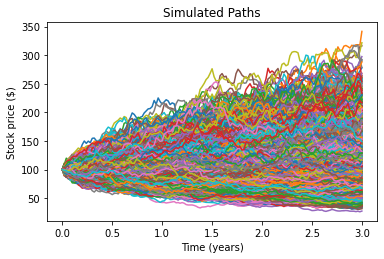

In [16]:
model.plot_paths()